# Show samples on frequency domain

This notebook will show all the samples per datasets on frequency domain.

1. Apply DFT over dataset windows
3. Plot UMAP and T-SNE

In [1]:
from pathlib import Path  # For defining dataset Paths
import sys
sys.path.append("../../..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
#from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.har.loaders import (
    KuHar_BalancedView20HzMotionSenseEquivalent,
    MotionSense_BalancedView20HZ,
    ExtraSensorySense_UnbalancedView20HZ,
    CHARM_BalancedView20Hz,
    WISDM_UnbalancedView20Hz,
    UCIHAR_UnbalancedView20Hz
)

from librep.datasets.multimodal import PandasMultiModalDataset, TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.transforms. stats import StatsTransform
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

2022-10-18 12:38:11.923553: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-18 12:38:11.923587: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Datasets to train the manifold

## Load ExtraSensory

In [3]:
# # Load ExtraSensory, creating PandasMultiModalDatasets with the correct pre-defined windows
# loader = ExtraSensorySenseUnbalancedResampledView20HZ("../../../data/views/ExtraSensory/unbalanced_20Hz_train-v1", download=False)
# train_val_es = loader.load()[0]

In [4]:
# train_val_es.data

In [5]:
# extrasensory_X = train_val_es.data.iloc[:,:-8]
# extrasensory_Y = train_val_es.data['standard activity code']
# tam = len(extrasensory_Y)
# extrasensory_id_dataset = np.array(['E']*tam)

## Load UCI-HAR

In [6]:
# Load MotionSense and create PandasMultiModalDatasets with the correct pre-defined windows
loader = UCIHAR_UnbalancedView20Hz("../../../data/views/UCI-HAR/unbalanced_20Hz_train_test_with_gravity_9.81_acc", 
                                   download=False) 
train_val_uci, test = loader.load(concat_train_validation=True, label='standard activity code')
train_val_uci.data['standard activity code'] = train_val_uci.data['standard activity code'].astype('int')
test.data['standard activity code'] = test.data['standard activity code'].astype('int')
train_val_uci, test

(PandasMultiModalDataset: samples=1992, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=818, features=360, no. window=6, label_columns='standard activity code')

In [7]:
train_val_uci.data

,accel-x0,accel-x1,accel-x2,accel-x3,accel-x4,accel-x5,accel-x6,accel-x7,accel-x8,accel-x9,...,gyro-z53,gyro-z54,gyro-z55,gyro-z56,gyro-z57,gyro-z58,gyro-z59,activity code,user,standard activity code
0,9.989105,10.017787,9.996324,9.985171,10.002932,9.998980,10.001955,10.004767,10.018205,10.010198,...,0.000240,-0.000519,-0.001399,0.001455,0.003015,0.010595,0.003470,5,1.0,1
1,10.017681,9.982960,10.013084,10.010305,9.993292,9.989414,10.029095,10.026851,9.990777,10.008107,...,-0.000780,-0.005341,-0.009295,-0.011561,-0.009854,-0.003153,0.000108,5,1.0,1
2,10.017944,10.005985,9.999447,9.996966,10.020134,10.027728,9.998624,10.006245,10.007884,10.010749,...,-0.000859,0.001881,0.003989,0.002610,0.000582,0.010218,0.021120,5,1.0,1
3,10.039228,10.019589,9.967760,10.025523,10.001139,10.021532,10.047259,9.987235,10.005131,9.997052,...,-0.002719,0.003975,0.001041,-0.004906,0.000427,-0.000771,-0.013023,5,1.0,1
4,9.994524,10.015744,10.024842,10.028226,10.000851,9.994540,10.035902,9.996244,10.017825,9.968293,...,0.002172,0.000114,0.000322,-0.001916,0.001534,0.002732,0.007108,5,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,9.827193,8.992926,10.358215,9.914678,10.994878,13.315179,15.468807,12.840666,10.036870,9.058110,...,-0.218047,-0.547776,-0.612564,-0.837015,-0.729588,-0.472352,-0.211776,2,27.0,3
1988,11.277669,11.377453,14.489377,14.430067,12.568149,9.705387,8.694315,8.570611,6.474507,6.597056,...,-0.476739,-0.819931,-0.750365,-0.630116,-0.337958,0.013349,0.153647,2,27.0,3
1989,10.999922,14.278959,14.940964,12.675182,9.919657,9.174817,8.640843,6.980949,6.380700,6.469734,...,0.120246,0.357961,0.001281,-0.054251,0.315337,0.080816,0.326850,2,27.0,3
1990,8.493095,6.271998,6.369654,7.635863,7.139909,7.421027,9.044668,10.677144,13.865690,16.299203,...,-0.229515,0.025977,0.066758,0.067897,0.115644,0.092375,0.298367,2,27.0,3


In [8]:
train_val_uci.data.iloc[:,:-3]

,accel-x0,accel-x1,accel-x2,accel-x3,accel-x4,accel-x5,accel-x6,accel-x7,accel-x8,accel-x9,...,gyro-z50,gyro-z51,gyro-z52,gyro-z53,gyro-z54,gyro-z55,gyro-z56,gyro-z57,gyro-z58,gyro-z59
0,9.989105,10.017787,9.996324,9.985171,10.002932,9.998980,10.001955,10.004767,10.018205,10.010198,...,-0.002097,-0.001315,0.002887,0.000240,-0.000519,-0.001399,0.001455,0.003015,0.010595,0.003470
1,10.017681,9.982960,10.013084,10.010305,9.993292,9.989414,10.029095,10.026851,9.990777,10.008107,...,-0.003287,0.002715,0.002455,-0.000780,-0.005341,-0.009295,-0.011561,-0.009854,-0.003153,0.000108
2,10.017944,10.005985,9.999447,9.996966,10.020134,10.027728,9.998624,10.006245,10.007884,10.010749,...,0.003624,0.005612,0.006521,-0.000859,0.001881,0.003989,0.002610,0.000582,0.010218,0.021120
3,10.039228,10.019589,9.967760,10.025523,10.001139,10.021532,10.047259,9.987235,10.005131,9.997052,...,-0.007704,-0.005069,0.005707,-0.002719,0.003975,0.001041,-0.004906,0.000427,-0.000771,-0.013023
4,9.994524,10.015744,10.024842,10.028226,10.000851,9.994540,10.035902,9.996244,10.017825,9.968293,...,0.006845,0.005905,0.006080,0.002172,0.000114,0.000322,-0.001916,0.001534,0.002732,0.007108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,9.827193,8.992926,10.358215,9.914678,10.994878,13.315179,15.468807,12.840666,10.036870,9.058110,...,0.775176,0.479487,0.243283,-0.218047,-0.547776,-0.612564,-0.837015,-0.729588,-0.472352,-0.211776
1988,11.277669,11.377453,14.489377,14.430067,12.568149,9.705387,8.694315,8.570611,6.474507,6.597056,...,0.258731,-0.231263,-0.481620,-0.476739,-0.819931,-0.750365,-0.630116,-0.337958,0.013349,0.153647
1989,10.999922,14.278959,14.940964,12.675182,9.919657,9.174817,8.640843,6.980949,6.380700,6.469734,...,-0.457300,-0.472327,-0.177299,0.120246,0.357961,0.001281,-0.054251,0.315337,0.080816,0.326850
1990,8.493095,6.271998,6.369654,7.635863,7.139909,7.421027,9.044668,10.677144,13.865690,16.299203,...,0.098396,0.205140,0.012599,-0.229515,0.025977,0.066758,0.067897,0.115644,0.092375,0.298367


In [9]:
uci_X = train_val_uci.data.iloc[:,:-3]
uci_Y = train_val_uci.data['standard activity code']

tam = len(uci_Y)
uci_id_dataset = np.array(['U']*tam)

## Load WISDM

In [10]:
# Load WISDM and create PandasMultiModalDatasets with the correct pre-defined windows
loader = WISDM_UnbalancedView20Hz("../../../data/views/WISDM/unbalanced_20Hz_train_test-v1", download=False)
train_val_wisdm, test_wisdm = loader.load(concat_train_validation=True,
                                          label='standard activity code')
train_val_wisdm.data

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59,activity code,user,standard activity code
0,-0.364761,-0.900995,1.988477,0.504245,-2.074267,-4.365631,-0.503460,1.585056,-0.192807,-1.778517,...,0.021654,-0.008257,-0.392786,-0.329143,-0.074698,-0.027220,0.314905,0,1600,2
1,0.081002,-0.059554,0.429260,1.072248,-2.011736,-4.792650,-2.087036,0.663866,0.317017,-1.504834,...,0.345166,0.294343,-0.417068,-0.172208,0.067521,0.406141,0.615971,0,1600,2
2,0.192588,-0.855499,-1.242746,0.316417,-1.833108,-4.946311,1.429507,1.555702,-1.230934,-2.758278,...,0.341863,0.039910,-0.253467,-0.607339,-0.102324,0.100644,0.608968,0,1600,2
3,1.506239,-1.887573,-0.375515,0.282729,-2.745547,-5.598461,-1.923976,1.519264,0.538521,-2.826598,...,0.408067,0.268658,-0.341150,-0.359142,-0.065309,-0.015974,0.365056,0,1600,2
4,-0.494237,-0.791543,0.976555,1.730751,-4.135104,-7.033570,-3.470397,-1.347896,0.434743,0.326745,...,-0.459501,0.421399,-0.182202,-0.406128,-0.590792,-0.174049,0.307581,0,1600,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10818,-0.705972,-0.726914,-0.808348,-0.727646,-0.519297,-0.706294,-0.778460,-0.935760,-0.656630,-0.765051,...,0.015264,0.003391,-0.007575,0.000763,0.015584,-0.014311,-0.016027,4,1635,1
10819,-0.608502,-0.795883,-0.552300,-0.851302,-0.894535,-0.706040,-0.784716,-0.855779,-0.704870,-0.683281,...,-0.003144,-0.002943,0.005729,-0.010290,-0.006023,-0.006458,-0.001189,4,1635,1
10820,-0.777215,-0.714181,-0.765897,-0.765035,-0.697754,-0.852415,-0.749396,-0.637518,-0.757676,-0.702906,...,-0.001254,0.006774,-0.001247,0.001032,0.006439,0.005181,0.011468,4,1635,1
10821,-1.073461,-0.614644,-0.764390,-0.546810,-0.874834,-0.619953,-0.698473,-0.924804,-0.704255,-0.736017,...,0.004119,0.000570,-0.035448,-0.028324,0.004960,0.002800,-0.004581,4,1635,1


In [11]:
train_val_wisdm.data.iloc[:,:-3]

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-50,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59
0,-0.364761,-0.900995,1.988477,0.504245,-2.074267,-4.365631,-0.503460,1.585056,-0.192807,-1.778517,...,-0.400735,-0.302704,-0.193205,0.021654,-0.008257,-0.392786,-0.329143,-0.074698,-0.027220,0.314905
1,0.081002,-0.059554,0.429260,1.072248,-2.011736,-4.792650,-2.087036,0.663866,0.317017,-1.504834,...,-0.425415,0.143507,-0.229825,0.345166,0.294343,-0.417068,-0.172208,0.067521,0.406141,0.615971
2,0.192588,-0.855499,-1.242746,0.316417,-1.833108,-4.946311,1.429507,1.555702,-1.230934,-2.758278,...,-0.369517,-0.031353,-0.265816,0.341863,0.039910,-0.253467,-0.607339,-0.102324,0.100644,0.608968
3,1.506239,-1.887573,-0.375515,0.282729,-2.745547,-5.598461,-1.923976,1.519264,0.538521,-2.826598,...,-0.667743,-0.639873,-0.394629,0.408067,0.268658,-0.341150,-0.359142,-0.065309,-0.015974,0.365056
4,-0.494237,-0.791543,0.976555,1.730751,-4.135104,-7.033570,-3.470397,-1.347896,0.434743,0.326745,...,-0.832488,0.009191,0.124568,-0.459501,0.421399,-0.182202,-0.406128,-0.590792,-0.174049,0.307581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10818,-0.705972,-0.726914,-0.808348,-0.727646,-0.519297,-0.706294,-0.778460,-0.935760,-0.656630,-0.765051,...,-0.002618,-0.014469,0.011366,0.015264,0.003391,-0.007575,0.000763,0.015584,-0.014311,-0.016027
10819,-0.608502,-0.795883,-0.552300,-0.851302,-0.894535,-0.706040,-0.784716,-0.855779,-0.704870,-0.683281,...,0.003346,-0.002748,0.002332,-0.003144,-0.002943,0.005729,-0.010290,-0.006023,-0.006458,-0.001189
10820,-0.777215,-0.714181,-0.765897,-0.765035,-0.697754,-0.852415,-0.749396,-0.637518,-0.757676,-0.702906,...,0.007118,0.003037,0.001493,-0.001254,0.006774,-0.001247,0.001032,0.006439,0.005181,0.011468
10821,-1.073461,-0.614644,-0.764390,-0.546810,-0.874834,-0.619953,-0.698473,-0.924804,-0.704255,-0.736017,...,-0.023223,-0.055126,-0.045073,0.004119,0.000570,-0.035448,-0.028324,0.004960,0.002800,-0.004581


In [12]:
train_val_wisdm.data['standard activity code'].unique()

array([2, 5, 6, 0, 1], dtype=object)

In [13]:
wisdm_X = np.array(train_val_wisdm.data.iloc[:,:-3])
wisdm_Y = np.array(train_val_wisdm.data['standard activity code'])

tam = len(wisdm_Y)
wisdm_id_dataset = np.array(['W']*tam)

## Load KuHar

In [14]:
# loader = KuHarResampledView20HZ("../../../../data/views/KuHar/balanced_20Hz_motionsense_equivalent-v1")

In [15]:
# train_val_kh, test_kh = loader.load(concat_train_validation=True)

In [16]:
# train_val_kh.data

In [17]:
# train_val_kh.data['standard activity code'].unique()

In [18]:
# train_val_kh.data.iloc[:,:-10]

In [19]:
# kuhar_X = np.array(train_val_kh.data.iloc[:,:-10])
# kuhar_Y = np.array(train_val_kh.data['standard activity code'])
# tam = len(kuhar_Y)
# kuhar_id_dataset = np.array(['K']*tam)

## Load MotionSense

In [20]:
# Load MotionSense and create PandasMultiModalDatasets with the correct pre-defined windows
loader = MotionSense_BalancedView20HZ("../../../data/views/MotionSense/balanced_20Hz_with_gravity_9.81_acc", 
                                      download=False)
train_val_motion, test = loader.load(concat_train_validation=True, 
                                     label="standard activity code")
train_val_motion, test

(PandasMultiModalDataset: samples=4020, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=1020, features=360, no. window=6, label_columns='standard activity code')

In [21]:
train_val_motion.data

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59,activity code,length,trial_code,index,user,standard activity code
0,2.728705,1.745033,1.747608,1.638583,2.269632,2.113769,0.898506,4.521329,-0.366598,2.253692,...,-0.171130,0.292608,0.932535,0.782147,0,150,1,150,11,4
1,-2.337406,0.492136,-1.905276,-0.792931,-3.633312,-2.010541,-1.999180,0.775418,5.222073,0.376617,...,0.241819,0.718420,0.336507,0.936563,0,150,1,900,12,4
2,2.374055,1.486684,2.128813,2.122220,2.159086,0.324434,1.700915,0.386075,2.253103,0.717394,...,0.732298,0.667477,-0.025386,-0.037093,0,150,1,1050,21,4
3,-0.008749,-1.415145,4.735210,6.788520,3.669158,-0.650310,3.426964,2.332666,-4.960264,7.540761,...,0.037076,-0.993926,-0.182277,0.317828,0,150,2,150,17,4
4,-1.186589,2.843267,-1.713601,1.908354,-0.582225,0.877230,-1.084176,-2.460460,-2.749313,-2.764776,...,0.496173,1.265226,1.502311,0.857408,0,150,11,450,21,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,0.438115,3.255994,-1.157529,5.054688,1.628169,3.667514,6.295931,-11.171494,-3.078356,2.127215,...,-0.589413,-1.091889,1.141263,-0.552978,5,150,9,3300,4,5
4016,-5.743063,-1.773532,17.991325,2.019050,-12.776854,0.271147,14.655750,-7.677687,7.842073,3.805292,...,2.611230,1.658511,1.304156,-2.120086,5,150,9,150,20,5
4017,9.088922,6.320772,3.282199,-1.925583,2.372136,0.010677,0.871883,-8.905142,8.317873,2.808271,...,1.016603,-1.277840,-2.122599,-1.689117,5,150,9,2550,7,5
4018,1.039400,-1.897114,-3.188452,-4.827097,4.312984,1.968542,-2.217618,-0.245953,1.426658,0.841435,...,1.358415,1.432210,0.481120,-2.242066,5,150,9,2250,7,5


In [22]:
train_val_motion.data.iloc[:,:-6]

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-50,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59
0,2.728705,1.745033,1.747608,1.638583,2.269632,2.113769,0.898506,4.521329,-0.366598,2.253692,...,0.338630,0.630162,0.010132,-0.357627,-0.270421,-0.099006,-0.171130,0.292608,0.932535,0.782147
1,-2.337406,0.492136,-1.905276,-0.792931,-3.633312,-2.010541,-1.999180,0.775418,5.222073,0.376617,...,-0.188645,0.175246,-0.369358,0.338468,-0.711659,-0.838042,0.241819,0.718420,0.336507,0.936563
2,2.374055,1.486684,2.128813,2.122220,2.159086,0.324434,1.700915,0.386075,2.253103,0.717394,...,0.105371,0.025860,1.168944,0.831773,-0.490816,0.497304,0.732298,0.667477,-0.025386,-0.037093
3,-0.008749,-1.415145,4.735210,6.788520,3.669158,-0.650310,3.426964,2.332666,-4.960264,7.540761,...,-2.477212,-1.612381,-0.416034,0.802364,0.116252,0.919908,0.037076,-0.993926,-0.182277,0.317828
4,-1.186589,2.843267,-1.713601,1.908354,-0.582225,0.877230,-1.084176,-2.460460,-2.749313,-2.764776,...,-0.533618,-0.931536,-0.890335,-0.515152,-0.552368,-0.060734,0.496173,1.265226,1.502311,0.857408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,0.438115,3.255994,-1.157529,5.054688,1.628169,3.667514,6.295931,-11.171494,-3.078356,2.127215,...,0.332628,-0.564182,1.271037,2.880865,2.318440,0.053538,-0.589413,-1.091889,1.141263,-0.552978
4016,-5.743063,-1.773532,17.991325,2.019050,-12.776854,0.271147,14.655750,-7.677687,7.842073,3.805292,...,-2.720648,-1.525806,-0.443669,0.836655,1.793170,2.214804,2.611230,1.658511,1.304156,-2.120086
4017,9.088922,6.320772,3.282199,-1.925583,2.372136,0.010677,0.871883,-8.905142,8.317873,2.808271,...,1.203391,0.940672,1.160005,0.241466,-1.654988,-0.728725,1.016603,-1.277840,-2.122599,-1.689117
4018,1.039400,-1.897114,-3.188452,-4.827097,4.312984,1.968542,-2.217618,-0.245953,1.426658,0.841435,...,-0.281189,-0.078258,0.658548,1.646081,1.596760,1.686676,1.358415,1.432210,0.481120,-2.242066


In [23]:
train_val_motion.data['standard activity code'].unique()

array([4, 3, 0, 1, 2, 5])

In [24]:
motion_X = np.array(train_val_motion.data.iloc[:,:-6])
motion_Y = np.array(train_val_motion.data['standard activity code'])
tam = len(motion_Y)
motion_id_dataset = np.array(['M']*tam)

## Load CHARM

In [25]:
# Load CHARM, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = CHARM_BalancedView20Hz("../../../data/views/CHARM/balanced_20Hz_train_test-v1", download=False)
train_val_charm, test_charm = loader.load(concat_train_validation=True, 
                                          label="standard activity code")
train_val_charm.data

,index,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,...,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59,activity code,user,standard activity code
0,0,-0.316044,-2.499959,-0.616105,0.353358,-0.824398,-0.810047,-1.138340,-1.589111,-1.370696,...,5.147284,5.167496,5.180790,5.222275,5.303915,5.373075,5.411260,0,0,0
1,1,-0.050466,0.074350,0.097396,0.084905,0.112700,0.134203,0.110953,0.088282,0.177306,...,5.111729,5.150032,5.159996,5.156902,5.147285,5.131298,5.108950,0,0,0
2,2,0.270301,0.028054,0.146652,0.376342,0.164298,0.253816,0.245170,0.202514,0.265768,...,5.437164,5.572677,5.670806,5.707042,5.675314,5.608472,5.544296,0,0,0
3,3,-0.683588,-1.033685,-1.154929,-0.492721,0.061972,0.130619,0.385515,0.393008,0.082072,...,5.380427,5.405318,5.438172,5.481835,5.538151,5.597009,5.640450,0,0,0
4,4,-0.185709,-0.083570,-0.230019,-0.157817,-0.349459,-0.400257,-0.079761,-0.236021,-0.043397,...,4.722800,4.969438,5.028447,4.880812,4.689925,4.580247,4.548837,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,975,-0.358002,-0.157281,-0.237719,-0.506597,-0.652816,-0.756904,-0.848554,-0.857909,-0.675477,...,9.600750,9.509793,9.398394,9.269391,9.125620,8.969915,8.805115,9,9,4
731,976,-0.577685,-0.746320,-0.771814,-0.852250,-0.770985,-0.792406,-0.938076,-0.706645,-0.654285,...,6.000710,6.061267,6.124409,6.190054,6.258116,6.328513,6.401161,9,9,4
732,977,0.623657,0.911399,0.517688,-0.015968,-0.219780,-0.215724,-0.340050,-0.973663,-1.091267,...,10.979259,10.886837,10.772225,10.637316,10.484001,10.314175,10.129730,9,9,4
733,978,-0.367026,-0.345516,-0.047627,0.259660,0.393635,0.374339,0.522283,0.734257,1.208773,...,6.818254,6.695461,6.587442,6.498150,6.431536,6.391555,6.382158,9,9,4


In [26]:
train_val_charm.data.iloc[:,1:-3]

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-50,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59
0,-0.316044,-2.499959,-0.616105,0.353358,-0.824398,-0.810047,-1.138340,-1.589111,-1.370696,-0.703873,...,5.141144,5.120107,5.126820,5.147284,5.167496,5.180790,5.222275,5.303915,5.373075,5.411260
1,-0.050466,0.074350,0.097396,0.084905,0.112700,0.134203,0.110953,0.088282,0.177306,0.145449,...,5.112808,5.018489,5.044690,5.111729,5.150032,5.159996,5.156902,5.147285,5.131298,5.108950
2,0.270301,0.028054,0.146652,0.376342,0.164298,0.253816,0.245170,0.202514,0.265768,0.320114,...,5.052559,5.152483,5.288892,5.437164,5.572677,5.670806,5.707042,5.675314,5.608472,5.544296
3,-0.683588,-1.033685,-1.154929,-0.492721,0.061972,0.130619,0.385515,0.393008,0.082072,-0.764478,...,5.325069,5.343148,5.360652,5.380427,5.405318,5.438172,5.481835,5.538151,5.597009,5.640450
4,-0.185709,-0.083570,-0.230019,-0.157817,-0.349459,-0.400257,-0.079761,-0.236021,-0.043397,0.095293,...,4.639179,4.496824,4.510063,4.722800,4.969438,5.028447,4.880812,4.689925,4.580247,4.548837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,-0.358002,-0.157281,-0.237719,-0.506597,-0.652816,-0.756904,-0.848554,-0.857909,-0.675477,-0.601827,...,9.722618,9.709999,9.668431,9.600750,9.509793,9.398394,9.269391,9.125620,8.969915,8.805115
731,-0.577685,-0.746320,-0.771814,-0.852250,-0.770985,-0.792406,-0.938076,-0.706645,-0.654285,-0.635534,...,5.835391,5.887688,5.942822,6.000710,6.061267,6.124409,6.190054,6.258116,6.328513,6.401161
732,0.623657,0.911399,0.517688,-0.015968,-0.219780,-0.215724,-0.340050,-0.973663,-1.091267,-0.706216,...,11.104447,11.089956,11.047596,10.979259,10.886837,10.772225,10.637316,10.484001,10.314175,10.129730
733,-0.367026,-0.345516,-0.047627,0.259660,0.393635,0.374339,0.522283,0.734257,1.208773,1.106555,...,7.235746,7.092349,6.951867,6.818254,6.695461,6.587442,6.498150,6.431536,6.391555,6.382158


In [27]:
train_val_charm.data.iloc[:,:-2]

,index,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,...,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59,activity code
0,0,-0.316044,-2.499959,-0.616105,0.353358,-0.824398,-0.810047,-1.138340,-1.589111,-1.370696,...,5.120107,5.126820,5.147284,5.167496,5.180790,5.222275,5.303915,5.373075,5.411260,0
1,1,-0.050466,0.074350,0.097396,0.084905,0.112700,0.134203,0.110953,0.088282,0.177306,...,5.018489,5.044690,5.111729,5.150032,5.159996,5.156902,5.147285,5.131298,5.108950,0
2,2,0.270301,0.028054,0.146652,0.376342,0.164298,0.253816,0.245170,0.202514,0.265768,...,5.152483,5.288892,5.437164,5.572677,5.670806,5.707042,5.675314,5.608472,5.544296,0
3,3,-0.683588,-1.033685,-1.154929,-0.492721,0.061972,0.130619,0.385515,0.393008,0.082072,...,5.343148,5.360652,5.380427,5.405318,5.438172,5.481835,5.538151,5.597009,5.640450,0
4,4,-0.185709,-0.083570,-0.230019,-0.157817,-0.349459,-0.400257,-0.079761,-0.236021,-0.043397,...,4.496824,4.510063,4.722800,4.969438,5.028447,4.880812,4.689925,4.580247,4.548837,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,975,-0.358002,-0.157281,-0.237719,-0.506597,-0.652816,-0.756904,-0.848554,-0.857909,-0.675477,...,9.709999,9.668431,9.600750,9.509793,9.398394,9.269391,9.125620,8.969915,8.805115,9
731,976,-0.577685,-0.746320,-0.771814,-0.852250,-0.770985,-0.792406,-0.938076,-0.706645,-0.654285,...,5.887688,5.942822,6.000710,6.061267,6.124409,6.190054,6.258116,6.328513,6.401161,9
732,977,0.623657,0.911399,0.517688,-0.015968,-0.219780,-0.215724,-0.340050,-0.973663,-1.091267,...,11.089956,11.047596,10.979259,10.886837,10.772225,10.637316,10.484001,10.314175,10.129730,9
733,978,-0.367026,-0.345516,-0.047627,0.259660,0.393635,0.374339,0.522283,0.734257,1.208773,...,7.092349,6.951867,6.818254,6.695461,6.587442,6.498150,6.431536,6.391555,6.382158,9


In [28]:
train_val_charm.data['standard activity code'].unique()

array([0, 1, 2, 5, 3, 4], dtype=object)

In [29]:
charm_X = np.array(train_val_charm.data.iloc[:,1:-3])
charm_Y = np.array(train_val_charm.data['standard activity code'])
tam = len(charm_Y)
charm_id_dataset = np.array(['C']*tam)

# Prepare the data

In [30]:
columns = list(train_val_charm.data.iloc[:,1:-3].columns)

In [31]:
data_X = np.concatenate([charm_X, motion_X, wisdm_X, uci_X])
data_Y = np.concatenate([charm_Y, motion_Y, wisdm_Y, uci_Y])
data_id_dataset = np.concatenate([charm_id_dataset, motion_id_dataset, wisdm_id_dataset, 
                                  uci_id_dataset])

In [32]:
data = pd.DataFrame(data_X, columns=columns)
data['standard activity code'] = data_Y
data['Id Dataset'] = data_id_dataset

In [33]:
# Features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
train = PandasMultiModalDataset(
    data,
    feature_prefixes=features,
    label_columns="Id Dataset",
    as_array=True
)

In [34]:
# Create the objects
fft_transform = FFT()

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[fft_transform], 
                new_window_name_prefix="fft."
)

# Plot the manifold on frequency domain

## Some functions

In [35]:
def plot(df, figsize: tuple = (5, 5), title: str = None, labels: dict = None):
    fig, ax = plt.subplots(figsize=figsize)
    # marker = {'KuHar': '.', 
    #           'MotionSense': '2',
    #           'CHARM': '1',
    #           'ExtraSensory': '+',
    #           'WISDM': 'x',
    #           'UCI': '4',
    #          }
    marker = {'MotionSense': '2',
              'CHARM': '1',
              'WISDM': 'x',
              'UCI': '4',
             }
    for label, group_df in df.groupby("label"):
        label = labels[label] if labels is not None else label
        ax.scatter(group_df.x, group_df.y, label=label, marker=marker[label])
    ax.legend()
    plt.title(title)
    plt.show()

In [36]:
def plot_classes(df, figsize: tuple = (5, 5), title: str = None, labels: dict = None):
    fig, ax = plt.subplots(figsize=figsize)
    marker = {
        "Sit": '.',
        "Stand": '2',
        "Walk": '1',
        "Upstairs": '+',
        "Downstairs": 'x',
        "Run / Jogging": '4',
        "stair up and down": '3'
}
    for label, group_df in df.groupby("label"):
        label = labels[label] if labels is not None else label
        ax.scatter(group_df.x, group_df.y, label=label, marker=marker[label])
    ax.legend()
    plt.title(title)
    plt.show()

In [37]:
combinations =  [
    # ['K', 'M'], 
    # ['K','C'], 
    # ['K','E'], 
    # ['K','W'], 
    # ['K','U'],
    # ['M','C'],
    # ['M','E'],
    # ['M','W'],
    # ['M','U'],
    # ['C','E'],
    # ['C','W'],
    # ['C','U'],
    # ['E','W'],
    # ['E','U'],
    # ['W','U'],
    # ['K','M','C','E','W','U']
    ['M','C','W','U']

]
    # ['Ktr','Kts'],
    # Mtr,Mts
    # Ctr,Cts
    # Etr,Ets
    # Wtr,Wts
    # Utr,Uts

# labels = {'K': 'KuHar', 
#           'M': 'MotionSense',
#           'C': 'CHARM',
#           'E': 'ExtraSensory',
#           'W': 'WISDM',
#           'U': 'UCI',
#          }
labels = {
          'M': 'MotionSense',
          'C': 'CHARM',
          'W': 'WISDM',
          'U': 'UCI',
         }

# KuHAR	K
# MotionSense	M
# CHARM	C
# ExtraSensory	E
# WISDM	W
# UCI	U

In [38]:
# Create the objects

fft_transform = FFT()

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[fft_transform], 
                new_window_name_prefix="fft."
)

In [39]:
# X = data[data['Id Dataset'].isin(['C', 'K'])]
# X
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

## Plot datasets separeting per dataset

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


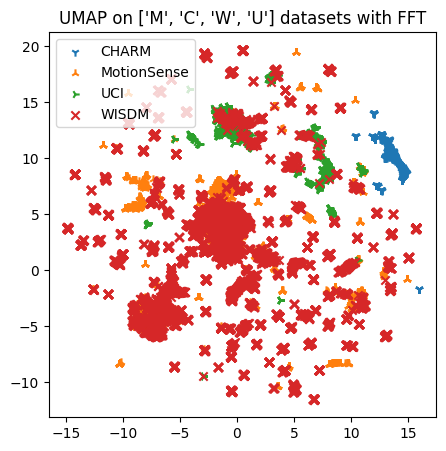

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


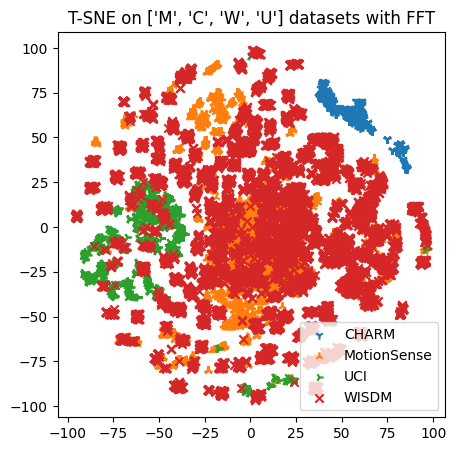

In [40]:
for combination in combinations:
    
    data_transformed = data[data['Id Dataset'].isin(combination)]

    # Creating the datasets
    data_transformed = PandasMultiModalDataset(
        data_transformed,
        feature_prefixes=features,
        label_columns="Id Dataset",
        as_array=True
    )
    
    data_fft = transformer(data_transformed)
    
    model = UMAP(n_components=2, random_state=42)
    result = pd.DataFrame(model.fit_transform(data_fft[:][0]), columns=["x", "y"])
    result["label"] = data_fft[:][1]
    plot(result, title="UMAP on {} datasets with FFT".format(combination), labels = labels)
    
    model = TSNE(n_components=2, random_state=42)
    result = pd.DataFrame(model.fit_transform(data_fft[:][0]), columns=["x", "y"])
    result["label"] = data_fft[:][1]
    plot(result, title="T-SNE on {} datasets with FFT".format(combination), labels=labels)

## Plot datasets separeting per classes

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


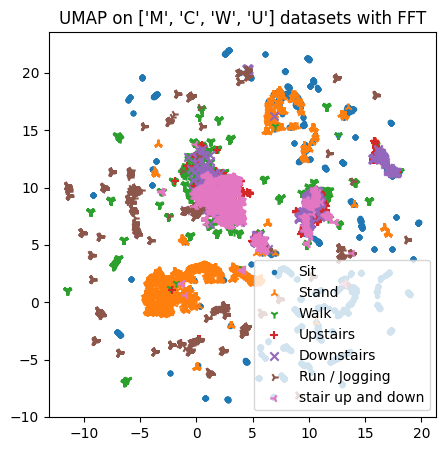

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


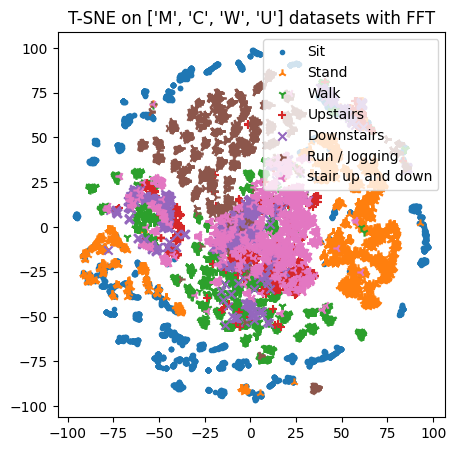

In [41]:
classes_names = {
    0: "Sit",
    1: "Stand", 
    2: "Walk",
    3: "Upstairs",
    4: "Downstairs",
    5: "Run / Jogging",
    6: "stair up and down"
}

for combination in combinations:
    
    data_transformed = data[data['Id Dataset'].isin(combination)]

    # Creating the datasets
    data_transformed = PandasMultiModalDataset(
        data_transformed,
        feature_prefixes=features,
        label_columns='standard activity code',
        as_array=True
    )
    
    data_fft = transformer(data_transformed)
    
    
    model = UMAP(n_components=2, random_state=42)
    result = pd.DataFrame(model.fit_transform(data_fft[:][0]), columns=["x", "y"])
    result["label"] = data_fft[:][1]
    plot_classes(result, title="UMAP on {} datasets with FFT".format(combination), labels = classes_names)
    
    model = TSNE(n_components=2, random_state=42)
    result = pd.DataFrame(model.fit_transform(data_fft[:][0]), columns=["x", "y"])
    result["label"] = data_fft[:][1]
    plot_classes(result, title="T-SNE on {} datasets with FFT".format(combination), labels= classes_names)

## Plot classes separeting per dataset

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


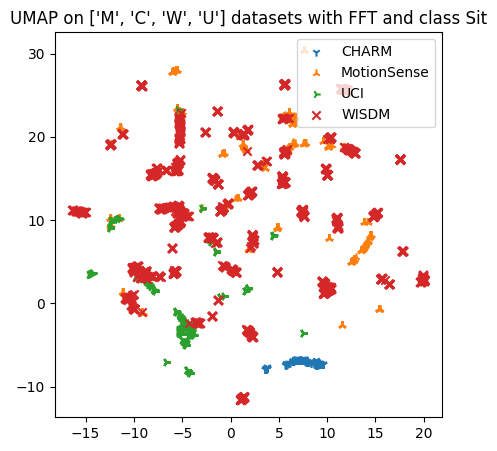

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


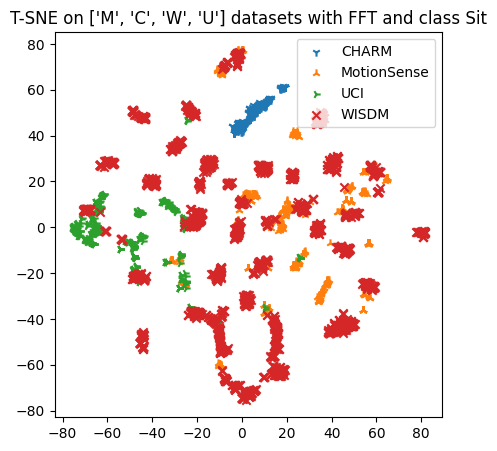

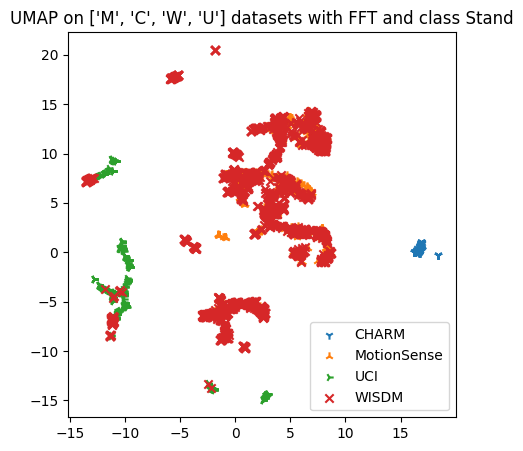

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


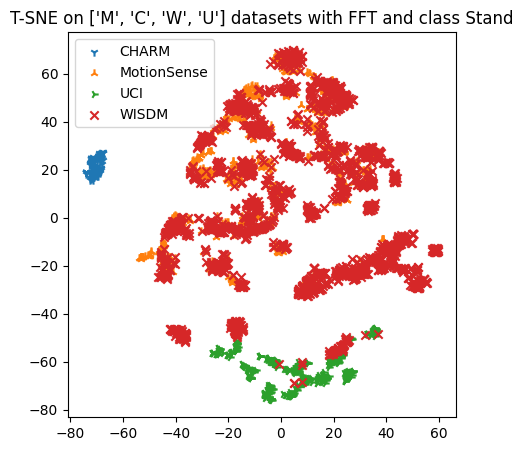

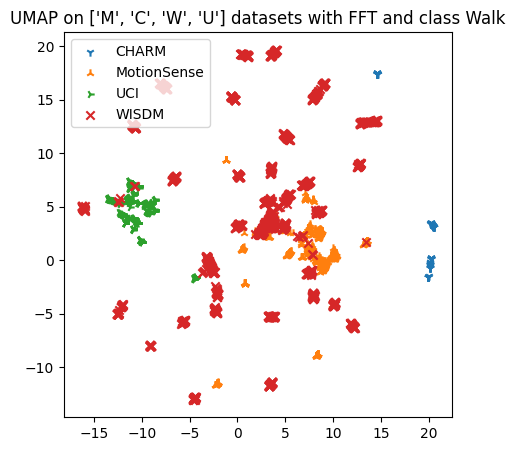

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


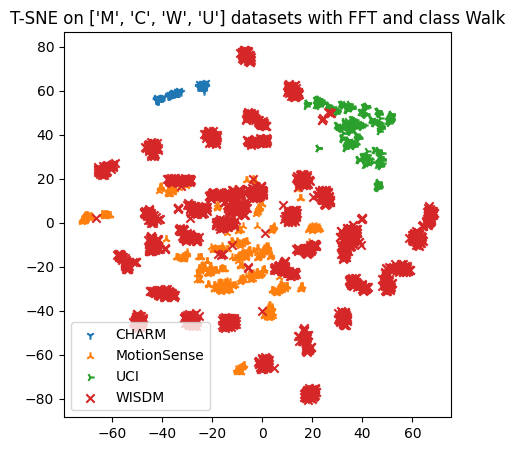

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


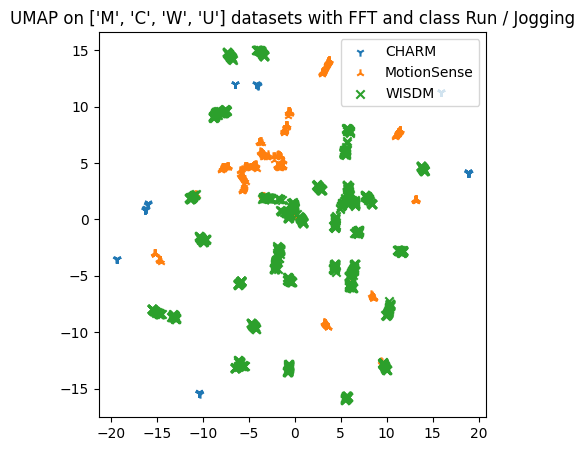

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
classes_names = {
    0: "Sit",
    1: "Stand", 
    2: "Walk",
    3: "Upstairs",
    4: "Downstairs",
    5: "Run / Jogging",
    6: "stair up and down"
}

for combination in combinations:
    
    data_transformed = data[data['Id Dataset'].isin(combination)]
    # data_transformed['standard activity code'] = data_transformed['standard activity code'].astype('int')
    classes = list(data_transformed['standard activity code'].unique())
    
    for classe in classes:
        data_transformed_classes = data_transformed[data_transformed['standard activity code'].isin([classe])]

        # Creating the datasets
        data_transformed_classes = PandasMultiModalDataset(
            data_transformed_classes,
            feature_prefixes=features,
            label_columns='Id Dataset',
            as_array=True
        )

        data_fft = transformer(data_transformed_classes)

        model = UMAP(n_components=2, random_state=42)
        result = pd.DataFrame(model.fit_transform(data_fft[:][0]), columns=["x", "y"])
        result["label"] = data_fft[:][1]
        plot(result, title="UMAP on {} datasets with FFT and class {}".format(combination, 
                                                                              classes_names[classe]), 
             labels = labels)

        model = TSNE(n_components=2, random_state=42)
        result = pd.DataFrame(model.fit_transform(data_fft[:][0]), columns=["x", "y"])
        result["label"] = data_fft[:][1]
        plot(result, title="T-SNE on {} datasets with FFT and class {}".format(combination, 
                                                                               classes_names[classe]), 
             labels=labels)